<a href="https://colab.research.google.com/github/kanepickrell/memory-bridge/blob/main/memory_bridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [355]:
from IPython.display import Javascript

def auto_run():
    display(Javascript('''
        setInterval(() => {
            document.querySelectorAll(".cell-execution-indicator").forEach((btn) => {
                btn.parentElement.querySelector("button[title='Run cell']").click();
            });
        }, 5000);
    '''))

auto_run()

<IPython.core.display.Javascript object>

In [336]:
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import requests
import json
import pandas as pd
from google.colab import files

In [337]:
import requests

url = "https://raw.githubusercontent.com/kanepickrell/memory-bridge/main/MemoryFiles/MemoryFileV2.json"
response = requests.get(url)

if response.status_code == 200:
    try:
        data = response.json()
        print(data)
    except requests.exceptions.JSONDecodeError:
        print("Error: Response is not valid JSON")
        print(response.text)
else:
    print("Error fetching file:", response.status_code)

{'people': [{'id': 'p1', 'name': 'John Doe', 'age': 35, 'relationship': 'Friend', 'description': 'A long-time friend from college who enjoys hiking and photography.', 'tags': ['friend', 'college', 'hiking', 'photography'], 'recall_strength': 0.85}, {'id': 'p2', 'name': 'Jane Smith', 'age': 29, 'relationship': 'Sister', 'description': 'Younger sister who works as a software engineer.', 'tags': ['family', 'sister', 'tech'], 'recall_strength': 0.92}], 'events': [{'id': 'e1', 'date': '2023-07-15', 'related_people': [['p1', 0.9], ['p2', 0.8]], 'description': 'A hiking trip to the Grand Canyon with John and Jane.', 'tags': ['hiking', 'trip', 'adventure'], 'related_places': [['l1', 1.0]], 'recall_strength': 0.78}, {'id': 'e2', 'date': '2022-12-25', 'related_people': [['p2', 1.0]], 'description': "Christmas celebration at Jane's place.", 'tags': ['holiday', 'family', 'Christmas'], 'related_places': [['l2', 1.0]], 'recall_strength': 0.88}], 'locations': [{'id': 'l1', 'name': 'Grand Canyon', 'ad

In [338]:
df = pd.DataFrame(data)

In [339]:
df.head()

,people,events,locations
0,"{'id': 'p1', 'name': 'John Doe', 'age': 35, 'r...","{'id': 'e1', 'date': '2023-07-15', 'related_pe...","{'id': 'l1', 'name': 'Grand Canyon', 'address'..."
1,"{'id': 'p2', 'name': 'Jane Smith', 'age': 29, ...","{'id': 'e2', 'date': '2022-12-25', 'related_pe...","{'id': 'l2', 'name': 'Jane's Apartment', 'addr..."


In [340]:
df_people = pd.json_normalize(data, record_path=['people'])
df_events = pd.json_normalize(data, record_path=['events'])
df_locations = pd.json_normalize(data, record_path=['locations'])

In [341]:
df_events = df_events.explode('related_people')

In [342]:
df_events[['person_id', 'person_recall_strength']] = pd.DataFrame(df_events['related_people'].tolist(), index=df_events.index)

In [343]:
df_events.drop(columns=['related_people'], inplace=True)

In [344]:
df_merged = df_events.merge(df_people, left_on='person_id', right_on='id', how='left', suffixes=('_event', '_person'))

In [345]:
df_merged = df_merged.explode('related_places')

In [346]:
df_merged[['location_id', 'location_recall_strength']] = pd.DataFrame(df_merged['related_places'].tolist(), index=df_merged.index)

In [347]:
df_merged.drop(columns=['related_places'], inplace=True)

In [348]:
df_merged = df_merged.merge(df_locations, left_on='location_id', right_on='id', how='left', suffixes=('', '_location'))

In [349]:
df_merged.head()

,id_event,date,description_event,tags_event,recall_strength_event,person_id,person_recall_strength,id_person,name,age,...,description_person,tags_person,recall_strength_person,location_id,location_recall_strength,id,name_location,address,description,recall_strength
0,e1,2023-07-15,A hiking trip to the Grand Canyon with John an...,"[hiking, trip, adventure]",0.78,p1,0.9,p1,John Doe,35,...,A long-time friend from college who enjoys hik...,"[friend, college, hiking, photography]",0.85,l1,1.0,l1,Grand Canyon,"Arizona, USA",A breathtaking natural wonder known for its st...,0.95
1,e1,2023-07-15,A hiking trip to the Grand Canyon with John an...,"[hiking, trip, adventure]",0.78,p2,0.8,p2,Jane Smith,29,...,Younger sister who works as a software engineer.,"[family, sister, tech]",0.92,l1,1.0,l1,Grand Canyon,"Arizona, USA",A breathtaking natural wonder known for its st...,0.95
2,e2,2022-12-25,Christmas celebration at Jane's place.,"[holiday, family, Christmas]",0.88,p2,1.0,p2,Jane Smith,29,...,Younger sister who works as a software engineer.,"[family, sister, tech]",0.92,l2,1.0,l2,Jane's Apartment,"123 Main St, New York, NY",Jane's cozy apartment where she hosted Christm...,0.81


In [350]:
df_merged.columns.tolist()

['id_event',
 'date',
 'description_event',
 'tags_event',
 'recall_strength_event',
 'person_id',
 'person_recall_strength',
 'id_person',
 'name',
 'age',
 'relationship',
 'description_person',
 'tags_person',
 'recall_strength_person',
 'location_id',
 'location_recall_strength',
 'id',
 'name_location',
 'address',
 'description',
 'recall_strength']

In [351]:
G = nx.Graph()
node_colors = {}
node_sizes = {}


for _, row in df_merged.iterrows():
    event_node = f"{row['description_event']}"
    person_node = f"{row['name']} ({row['relationship']})"
    location_node = f"{row['name_location']}"


    event_node = "\n".join(textwrap.wrap(event_node, width=25))
    person_node = "\n".join(textwrap.wrap(person_node, width=20))
    location_node = "\n".join(textwrap.wrap(location_node, width=20))


    G.add_node(event_node, type="event")
    G.add_node(person_node, type="person")
    G.add_node(location_node, type="location")


    node_colors[event_node] = "lightblue"
    node_colors[person_node] = "teal"
    node_colors[location_node] = "green"


    node_sizes[event_node] = row['recall_strength_event'] * 800
    node_sizes[person_node] = row['recall_strength_person'] * 600
    node_sizes[location_node] = row['recall_strength'] * 700


    G.add_edge(event_node, person_node, weight=row['recall_strength_event'] * 5)
    G.add_edge(event_node, location_node, weight=row['location_recall_strength'] * 5)

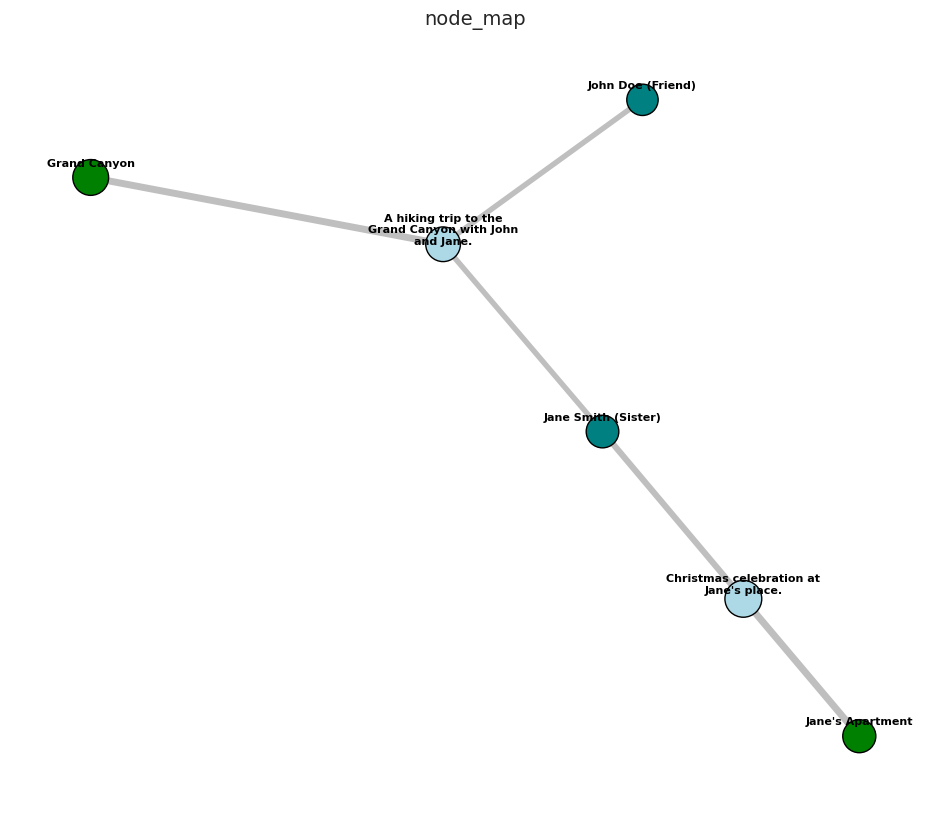

In [352]:
pos = nx.spring_layout(G, seed=63)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="grey")
nx.draw_networkx_nodes(G, pos, node_size=[node_sizes[n] for n in G.nodes()],
                       node_color=[node_colors[n] for n in G.nodes()], edgecolors="black")
label_pos = {k: (v[0], v[1] + 0.04) for k, v in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=8, font_color="black", font_weight="bold")
plt.title("node_map", fontsize=14)
plt.axis("off")
plt.show()